In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import pandas as pd
from sklearn import preprocessing
from sklearn import linear_model

# Functions

In [2]:
def generateModel(N, p, const):
    """
    N (int): number of data points
    p (int): number of features
    const (float): constant factor to multiply the noise term when generating targets
    """
    X = np.random.randn(N, p) # random data
    w = np.random.randn(p, 1) # random weights
    noise = np.random.randn(N, 1) # noise
    y = X @ w + const * noise # generate linear model with some noise
    
    return X, y, w

In [3]:
def linearRegressionPseudoInverse(X, y):
    
    w = np.linalg.inv((X.T @ X)) @X.T @ y # pseudo inverse analytical solution to linear regression
    
    return w

In [4]:
def linearRegressionGradientDescent(X, y, maxiters = 100, learning_rate = 0.0001):
    p = X.shape[1] # number of features
    w = np.random.randn(p,1) # random inital weights
    
    errors = list() # initialise a list to store a history of the errors
    e0 = np.linalg.norm(X @ w - y) # calculate the initial error
    errors.append(e0) # add the inital error to the history
    
    for _ in range(maxiters): # number of updates to perform
        
        w -= learning_rate * X.T @ (X @ w - y) # small shift to the weights based on the gradient
        
        e_iter = np.linalg.norm(X @ w - y)
        errors.append(e_iter)
        
    return w, errors
        
        

In [5]:
def linearRegressionMiniBatchGradientDescent(X, y, maxiters = 500, learning_rate = 0.001, batch_size = 5):
    p = X.shape[1]
    N = X.shape[0] # number of data points or samples
    w = np.random.randn(p,1)
    
    errors = list()
    e0 = np.linalg.norm(X @ w - y)
    errors.append(e0)
    
    for _ in range(maxiters):
        
        points = np.random.choice(N, batch_size, False) # randomly choose batch_size numer of indices 
        
        X_sub = X[points, :] # get the values and targets of the data at indices
        y_sub = y[points, :]
        
        w -= learning_rate * X_sub.T @ (X_sub @ w - y_sub)
        
        e_iter = np.linalg.norm(X @ w - y)
        errors.append(e_iter)
        
    return w, errors

In [6]:
def linearRegressionStochasticGradientDescent(X, y, maxiters = 2500, learning_rate = 0.05):
    p = X.shape[1]
    N = X.shape[0]
    w = np.random.randn(p,1)
    
    errors = list()
    e0 = np.linalg.norm(X @ w - y)
    errors.append(e0)
    
    for _ in range(maxiters):
        
        i = np.random.randint(0, N) # choose 1 index at random
        
        xi = X[i,:].reshape((p,1))
        yi = y[i,:]
        
        ypred = xi.T @ w
        
        w -= learning_rate * (ypred - yi) * xi
        
        e_iter = np.linalg.norm(X @ w - y)
        errors.append(e_iter)
        
    return w, errors

In [7]:
def RLS(X, y, lam = 1):
    
    check_convergence = True
    converged_iter = None
    
    N = X.shape[0]
    p = X.shape[1]
    
    X0 = X[:p,:] # start with p data points so the pseudo inverse solution can exist
    y0 = y[:p,:]
    
    P_new = np.eye(p) # identity matrix pxp, acting as the initial inverse of the covariance matrix X.T @ X
    
    w_new =  P_new @ X0.T @ y0 # initial calculation of the weights
    
    errors = list()
    
    E = np.linalg.norm(X @ w_new - y)
    
    errors.append(E)
    
    iteration = 0
    for i in range(N):
        iteration += 1
        
        x_n = X[i,:].reshape((p,1)) # get the next data point
        y_n = y[i]
        
        P_old = P_new # store a copy of the new values into the old variable so variables can be updated and not overwritten
        w_old = w_new
        
        k_n = ((1/lam)*P_old @ x_n)/(1+(1/lam)*x_n.T @ P_old @ x_n) # Kalman gain term
        e_n = y_n - w_old.T @ x_n # error calculation
        w_new = w_old + k_n * e_n # update to the weights using the kalman gain term
        P_new = (1/lam)*P_old - (1/lam)*k_n @ x_n.T @ P_old # update the approximation of the covariance matrix using the sample x_n
        
        E = np.linalg.norm(X @ w_new - y)
        errors.append(E)
        
        if check_convergence and iteration > 10:
            if np.abs(errors[-1] - errors[-10]) < 0.05: # proxy for convergence, if the error has not changed by more than 0.05 in 10 iters
                converged_iter = i - p
                check_convergence = False
        
        
    return w_new, errors, converged_iter

# Generate Data

In [8]:
N, p, const = 500, 30, 0.8 # samples, num features, noise magnitude

X, y, wtrue = generateModel(N, p, const)

# Pseudo Inverse Solution

In [265]:
w_pseudo = linearRegressionPseudoInverse(X, y)
ypred_pseudo = X @ w_pseudo # predictions using pseudo inverse weights

np.linalg.norm(ypred_pseudo - y) # calculate error

17.086302883556513

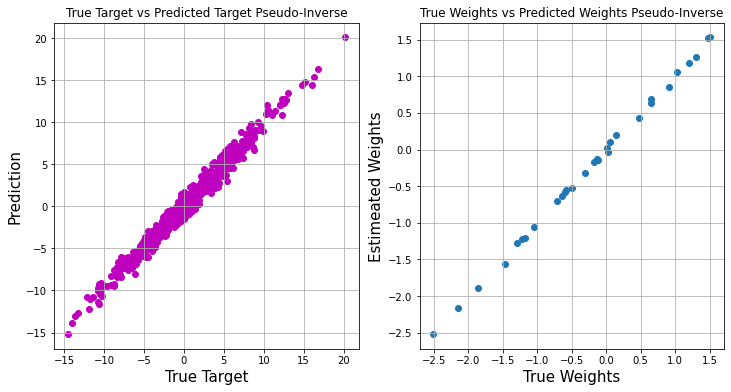

In [9]:
fig_pseudo, ax_pseudo = plt.subplots(ncols=2,figsize = (12,6))

ax_pseudo[0].scatter(y, ypred_pseudo, c = 'm')
ax_pseudo[0].grid()
ax_pseudo[0].set_title('True Target vs Predicted Target Pseudo-Inverse')
ax_pseudo[0].set_xlabel('True Target', fontsize=15)
ax_pseudo[0].set_ylabel('Prediction', fontsize=15)


ax_pseudo[1].scatter(wtrue, w_pseudo)
ax_pseudo[1].grid()
ax_pseudo[1].set_title('True Weights vs Predicted Weights Pseudo-Inverse')
ax_pseudo[1].set_xlabel('True Weights', fontsize=15)
ax_pseudo[1].set_ylabel('Estimeated Weights', fontsize=15)

plt.show()

# fig_pseudo.savefig('True_vs_pred_pseudo.pdf')

# Gradient Descent

In [37]:
iters = 150

w_GD, errors_GD = linearRegressionGradientDescent(X, y, iters)
ypred_GD = X @ w_GD

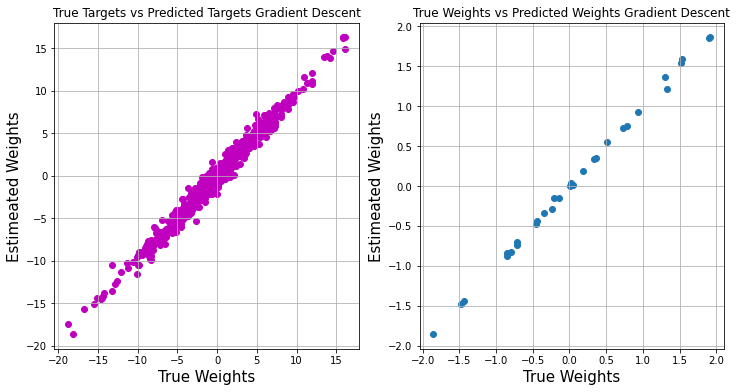

In [38]:
fig_GD, ax_GD = plt.subplots(ncols=2,figsize = (12,6))

ax_GD[0].scatter(y, ypred_GD, c = 'm')
ax_GD[0].grid()
ax_GD[0].set_title('True Targets vs Predicted Targets Gradient Descent')
ax_GD[0].set_xlabel('True Weights', fontsize=15)
ax_GD[0].set_ylabel('Estimeated Weights', fontsize=15)

ax_GD[1].scatter(wtrue, w_GD)
ax_GD[1].grid()
ax_GD[1].set_title('True Weights vs Predicted Weights Gradient Descent')
ax_GD[1].set_xlabel('True Weights', fontsize=15)
ax_GD[1].set_ylabel('Estimeated Weights', fontsize=15)

plt.show()

# fig_GD.savefig('True_vs_pred_GD.pdf')

In [39]:
errors_GD[-1]

17.468877523276504

Text(0, 0.5, 'error')

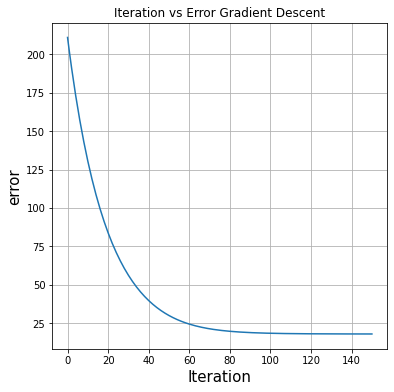

In [12]:
fig_GD_L, ax_GD_L = plt.subplots(figsize = (6,6))

ax_GD_L.plot(range(iters + 1), errors_GD)
ax_GD_L.grid()
ax_GD_L.set_title('Iteration vs Error Gradient Descent')
ax_GD_L.set_xlabel('Iteration', fontsize=15)
ax_GD_L.set_ylabel('error', fontsize=15)

# fig_GD_L.savefig('error_plot_GD.pdf')

# Mini Batch Gradient Descent

In [13]:
iters_MiniGD = 1000
batch = 5

w_MiniGD, errors_MiniGD = linearRegressionMiniBatchGradientDescent(X, y, iters_MiniGD, batch_size=batch)

ypred_MiniGD = X @ w_MiniGD

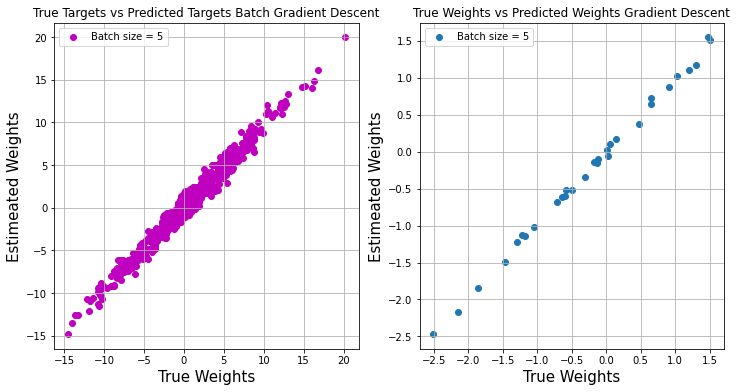

In [14]:
fig_MiniGD, ax_MiniGD = plt.subplots(ncols=2,figsize = (12,6))

ax_MiniGD[0].scatter(y, ypred_MiniGD, c = 'm', label='Batch size = ' + str(batch))
ax_MiniGD[0].grid()
ax_MiniGD[0].set_title('True Targets vs Predicted Targets Batch Gradient Descent')
ax_MiniGD[0].set_xlabel('True Weights', fontsize=15)
ax_MiniGD[0].set_ylabel('Estimeated Weights', fontsize=15)

ax_MiniGD[1].scatter(wtrue, w_MiniGD, label='Batch size = ' + str(batch))
ax_MiniGD[1].grid()
ax_MiniGD[1].set_title('True Weights vs Predicted Weights Gradient Descent')
ax_MiniGD[1].set_xlabel('True Weights', fontsize=15)
ax_MiniGD[1].set_ylabel('Estimeated Weights', fontsize=15)

ax_MiniGD[0].legend()
ax_MiniGD[1].legend()

# fig_MiniGD.savefig('True_vs_pred_Batch_GD.pdf')

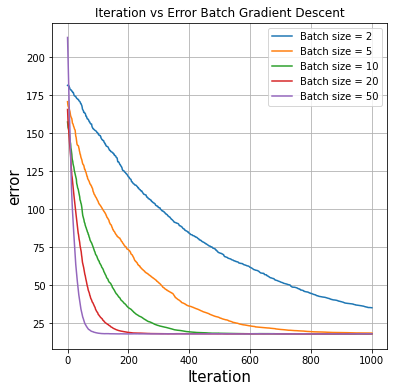

In [15]:
fig_MiniGD_size, ax_MiniGD_size = plt.subplots(figsize=(6,6))

batches = [2, 5, 10, 20, 50]
for b in batches:
    
    w_MiniGD_b, errors_MiniGD_b = linearRegressionMiniBatchGradientDescent(X, y, iters_MiniGD, batch_size=b)
    
    ax_MiniGD_size.plot(range(iters_MiniGD+1), errors_MiniGD_b, label = 'Batch size = ' + str(b))
    
ax_MiniGD_size.grid()
ax_MiniGD_size.set_title('Iteration vs Error Batch Gradient Descent')
ax_MiniGD_size.set_xlabel('Iteration', fontsize=15)
ax_MiniGD_size.set_ylabel('error', fontsize=15)

ax_MiniGD_size.legend()

# fig_MiniGD_size.savefig('error_plot_BatchGD_sizes.pdf')
    

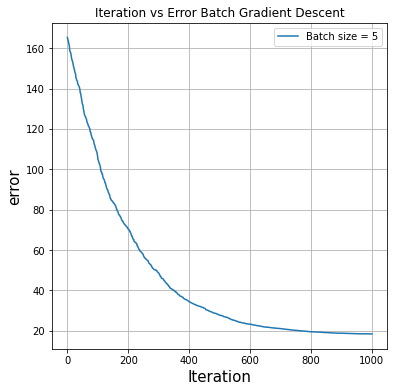

In [16]:
fig_MiniGD_L, ax_MiniGD_L = plt.subplots(figsize=(6,6))

ax_MiniGD_L.plot(range(iters_MiniGD+1), errors_MiniGD, label='Batch size = ' + str(batch))
ax_MiniGD_L.grid()
ax_MiniGD_L.set_title('Iteration vs Error Batch Gradient Descent')
ax_MiniGD_L.set_xlabel('Iteration', fontsize=15)
ax_MiniGD_L.set_ylabel('error', fontsize=15)

ax_MiniGD_L.legend()

# fig_MiniGD_L.savefig('error_plot_BatchGD.pdf')

# Stochastic Gradient Descent

In [40]:
iters_SGD = 2000

w_SGD, errors_SGD = linearRegressionStochasticGradientDescent(X, y, iters_SGD)

ypred_SGD = X @ w_SGD

Text(0, 0.5, 'Estimeated Weights')

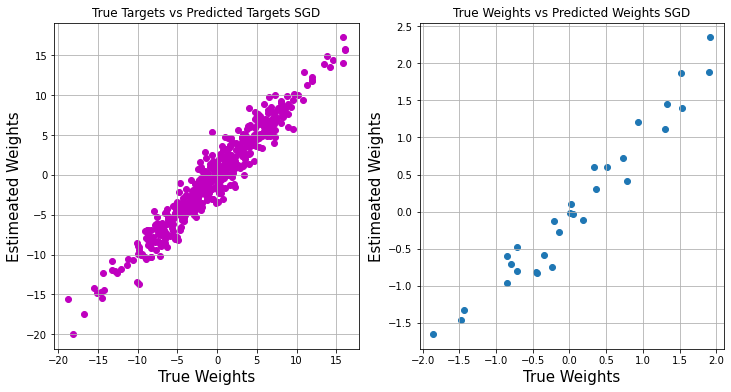

In [41]:
fig_SGD, ax_SGD = plt.subplots(ncols=2,figsize = (12,6))

ax_SGD[0].scatter(y, ypred_SGD, c = 'm')
ax_SGD[0].grid()
ax_SGD[0].set_title('True Targets vs Predicted Targets SGD')
ax_SGD[0].set_xlabel('True Weights', fontsize=15)
ax_SGD[0].set_ylabel('Estimeated Weights', fontsize=15)

ax_SGD[1].scatter(wtrue, w_SGD)
ax_SGD[1].grid()
ax_SGD[1].set_title('True Weights vs Predicted Weights SGD')
ax_SGD[1].set_xlabel('True Weights', fontsize=15)
ax_SGD[1].set_ylabel('Estimeated Weights', fontsize=15)

# fig_SGD.savefig('True_vs_pred_SGD.pdf')

Text(0, 0.5, 'error')

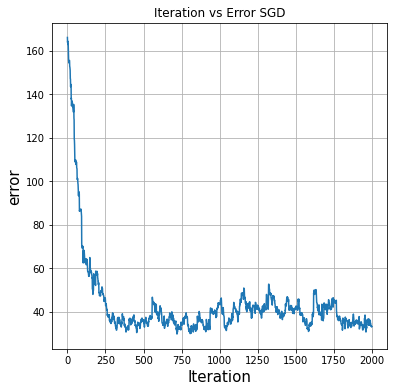

In [42]:
fig_SGD_L, ax_SGD_L = plt.subplots(figsize=(6,6))

ax_SGD_L.plot(range(iters_SGD+1), errors_SGD)
ax_SGD_L.grid()
ax_SGD_L.set_title('Iteration vs Error SGD')
ax_SGD_L.set_xlabel('Iteration', fontsize=15)
ax_SGD_L.set_ylabel('error', fontsize=15)

# fig_SGD_L.savefig('error_plot_SGD.pdf')

In [43]:
errors_SGD[-1]

33.20260427290189

# Recursive Least Squares (RLS)

In [11]:
N_RLS = 5000
p_RLS = [5, 10, 20, 50, 100, 200]

Text(0.5, 1.0, 'Iteration vs error for varying dimension sizes')

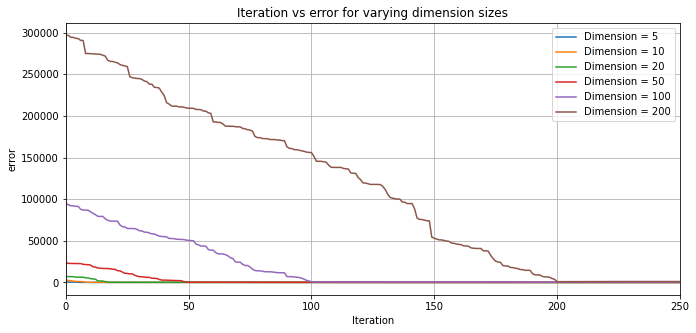

In [52]:
fig_RLS, ax_RLS = plt.subplots(figsize=(11,5))
converged_iter = list()
boxplots = dict()


for dim in p_RLS:
    converged_dim = list()
    for i in range(10): # run 10 samples for each number of features
        X_RLS, y_RLS, wtrue_RLS = generateModel(N_RLS, dim, 0.8) 
        _, e_RLS,c = RLS(X_RLS, y_RLS) # run Recursive Least Squares, only sotring the error and convergence iteration
        converged_dim.append(c)
    if i == 9: # if the end of the loop is reached
        ax_RLS.plot(range(len(e_RLS)), e_RLS, label = "Dimension = " + str(dim))
    #     converged_iter.append(converged_dim)
        boxplots[str(dim)] = converged_dim
    
ax_RLS.set_xlim((0,250))
ax_RLS.legend()
ax_RLS.grid()
ax_RLS.set_xlabel('Iteration')
ax_RLS.set_ylabel('error')
ax_RLS.set_title('Iteration vs error for varying dimension sizes')
# fig_RLS.savefig('convergence_dims.pdf')

In [56]:
fig_RLS.savefig('convergence_dims.pdf')

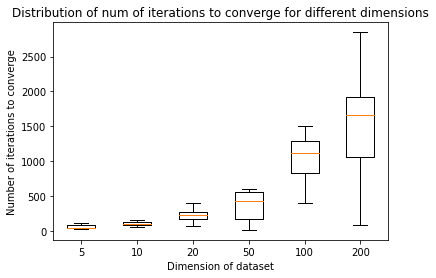

In [55]:
fig_conv, ax_conv = plt.subplots(figsize=(6,4))

labels, data = boxplots.keys(), boxplots.values()

ax_conv.boxplot(data)
plt.xticks(range(1, len(labels) + 1), labels)
ax_conv.set_xlabel('Dimension of dataset')
ax_conv.set_ylabel('Number of iterations to converge')
ax_conv.set_title('Distribution of num of iterations to converge for different dimensions')
plt.show()

fig_conv.savefig('covergence_boxplots.pdf')

# UCI Repository data

In [21]:
gt = pd.read_csv('gt_2015.csv')
print(gt.shape)
gt_numpy = preprocessing.MinMaxScaler().fit(gt).transform(gt)
t = gt_numpy[:,-1]
d = gt_numpy[:,:-1]

(7384, 11)


In [22]:
gt.head()

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX
0,1.95320,1020.1,84.985,2.5304,20.116,1048.7,544.92,116.27,10.799,7.4491,113.250
1,1.21910,1020.1,87.523,2.3937,18.584,1045.5,548.50,109.18,10.347,6.4684,112.020
2,0.94915,1022.2,78.335,2.7789,22.264,1068.8,549.95,125.88,11.256,3.6335,88.147
3,1.00750,1021.7,76.942,2.8170,23.358,1075.2,549.63,132.21,11.702,3.1972,87.078
4,1.28580,1021.6,76.732,2.8377,23.483,1076.2,549.68,133.58,11.737,2.3833,82.515


In [37]:
w_uci_sgd, errors_uci_sgd = linearRegressionStochasticGradientDescent(d, t.reshape((len(t), -1)), maxiters=len(d))

In [38]:
# %%timeit
w_uci_RLS, errors_uci_RLS, _ = RLS(d, t.reshape((len(t), -1)))

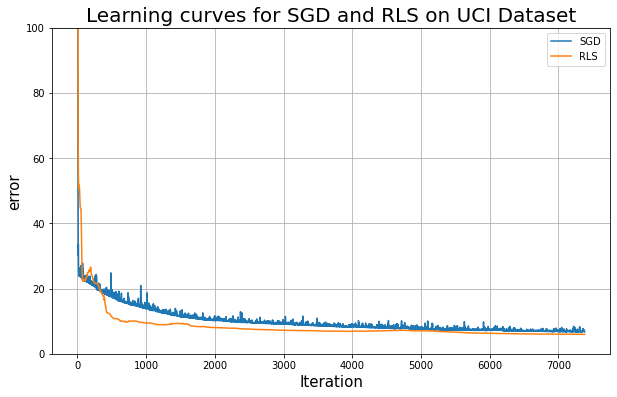

In [58]:
fig_uci, ax_uci = plt.subplots(figsize=(10,6))

ax_uci.plot(range(len(errors_uci_sgd)), errors_uci_sgd, label = 'SGD')
ax_uci.plot(range(len(errors_uci_RLS)), errors_uci_RLS, label = 'RLS')

ax_uci.set_ylim((0,100))
ax_uci.set_ylim((0,100))
ax_uci.legend()
ax_uci.grid()
ax_uci.set_xlabel('Iteration', fontsize = 15)
ax_uci.set_ylabel('error', fontsize = 15)
ax_uci.set_title('Learning curves for SGD and RLS on UCI Dataset', fontsize = 20)

fig_uci.savefig('plots/compare_curves.pdf')

In [59]:
preds = d @ w_uci_RLS

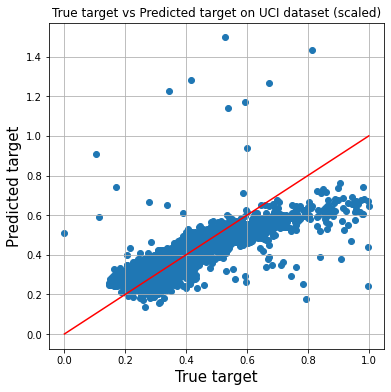

In [60]:
fig_preds, ax_preds = plt.subplots(figsize=(6,6))

ax_preds.scatter(t, preds)
ax_preds.plot([min(t), max(t)], [min(t), max(t)], c = 'r')
ax_preds.set_xlabel('True target', fontsize = 15)
ax_preds.set_ylabel('Predicted target', fontsize = 15)
ax_preds.grid()
ax_preds.set_title('True target vs Predicted target on UCI dataset (scaled)', fontsize = 12)

fig_preds.savefig('plots/predictions_UCI.pdf')

# Comparison

In [86]:
model = sm.RecursiveLS(t, d)
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 7384
Model:                    RecursiveLS   Log Likelihood                9291.187
Date:                Wed, 17 Feb 2021   R-squared:                       0.968
Time:                        15:58:16   AIC                         -18562.375
Sample:                             0   BIC                         -18493.304
                               - 7384   HQIC                        -18538.638
Covariance Type:            nonrobust   Scale                            0.005
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.4570      0.014    -33.183      0.000      -0.484      -0.430
x2            -0.0727      0.007    -10.917      0.000      -0.086      -0.060
x3            -0.1587      0.005    -28.913      0.000      -0.169      -0.148
x4             0.0224      0.017      1.327      0.184      -0.011       0.055
x5             0.1112      0.013      8.583      0.000       0.086       0.137
x6            -0.9936      0.044    -22.732      0.000      -1.079      -0.908
x7             0.8830      0.019     47.628      0.000       0.847       0.919
x8            -0.4444      0.074     -6.004      0.000      -0.590      -0.299
x9             1.7794      0.073     24.347      0.000       1.636       1.923
x10            1.3342      0.024     56.188      0.000       1.288       1.381
===================================================================================
Ljung-Box (L1) (Q):                3502.53   Jarque-Bera (JB):             26990.85
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.44   Skew:                             0.11
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.37
===================================================================================

Warnings:
[1] Parameters and covariance matrix estimates are RLS estimates conditional on the entire sample.
"""

In [84]:
np.linalg.norm((d @ res.recursive_coefficients.filtered[:,-1].reshape(10,-1) - d @ w_uci_RLS))

1.0768051659415738

In [76]:
w_uci_RLS.reshape(1, -1)

array([[-0.33482225, -0.00726265, -0.11721452, -0.03335235,  0.14017814,
        -0.62770121,  0.65187604,  0.07057915,  0.8210483 ,  1.36587306]])

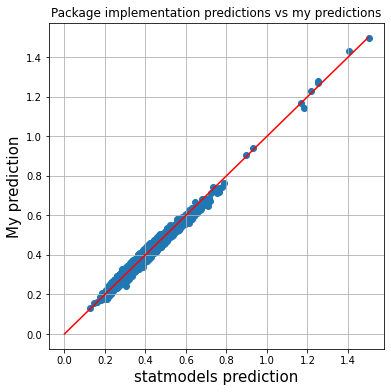

In [95]:
fig_imp_vs_statsmodel, ax_imp_vs_statsmodel = plt.subplots(figsize = (6,6))

ax_imp_vs_statsmodel.scatter(d @ res.recursive_coefficients.filtered[:,-1].reshape(-1,1), d @ w_uci_RLS)
ax_imp_vs_statsmodel.set_xlabel('statmodels prediction', fontsize = 15)
ax_imp_vs_statsmodel.set_ylabel('My prediction', fontsize = 15)
ax_imp_vs_statsmodel.plot([0,1.5], [0,1.5], c = 'r')
ax_imp_vs_statsmodel.grid()
ax_imp_vs_statsmodel.set_title('Package implementation predictions vs my predictions')

fig_imp_vs_statsmodel.savefig('plots/compare_package_preds.pdf')